In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import  Lasso, LogisticRegression
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, chi2, mutual_info_classif
from scipy.stats import shapiro, chi2_contingency
from scipy import stats

In [4]:
data = pd.read_csv('BigCitiesHealth.csv')

In [5]:
data.shape

(148292, 31)

In [6]:
data.columns

Index(['metric_item_label', 'metric_cat_label', 'metric_subcat_label',
       'metric_item_label_subtitle', 'metric_cat_item_yaxis_label',
       'metric_source_desc_label_fn', 'metric_source_desc_label_url_fn',
       'geo_label_city', 'geo_label_state', 'geo_label_citystate',
       'geo_fips_code', 'value', 'date_label', 'geo_label_proxy_or_real',
       'geo_label_proxy_footnote', 'geo_fips_desc', 'date_label_proxy_or_real',
       'date_label_proxy_footnote', 'value_ci_flag_yesno', 'value_95_ci_low',
       'value_95_ci_high', 'value_90_ci_low', 'value_90_ci_high',
       'geo_strata_region', 'geo_strata_poverty', 'geo_strata_Population',
       'geo_strata_PopDensity', 'geo_strata_Segregation', 'strata_race_label',
       'strata_sex_label', 'strata_race_sex_label'],
      dtype='object')

In [7]:
data.describe()

,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high,value_90_ci_low,value_90_ci_high
count,1.471950e+05,147522.000000,148292.000000,93378.000000,93388.000000,0.0,0.0
mean,2.880322e+06,830.377923,2015.227996,468.838106,568.740516,NaN,NaN
std,1.697827e+06,4304.120276,3.112534,1742.895189,2043.575501,NaN,NaN
min,4.550000e+05,-1.052184,2010.000000,-148.037039,0.458320,NaN,NaN
25%,8.200000e+05,10.851578,2013.000000,9.337966,15.449973,NaN,NaN
50%,2.938000e+06,26.743773,2015.000000,23.259248,34.061614,NaN,NaN
75%,4.748000e+06,77.161225,2018.000000,109.929802,149.434371,NaN,NaN
max,5.553000e+06,99408.000000,2020.000000,22650.600880,29193.761110,NaN,NaN


In [8]:
data['date_label'] = data['date_label'].astype(float)


In [9]:

data.dtypes

metric_item_label                   object
metric_cat_label                    object
metric_subcat_label                 object
metric_item_label_subtitle          object
metric_cat_item_yaxis_label         object
metric_source_desc_label_fn         object
metric_source_desc_label_url_fn     object
geo_label_city                      object
geo_label_state                     object
geo_label_citystate                 object
geo_fips_code                      float64
value                              float64
date_label                         float64
geo_label_proxy_or_real             object
geo_label_proxy_footnote            object
geo_fips_desc                       object
date_label_proxy_or_real            object
date_label_proxy_footnote           object
value_ci_flag_yesno                 object
value_95_ci_low                    float64
value_95_ci_high                   float64
value_90_ci_low                    float64
value_90_ci_high                   float64
geo_strata_

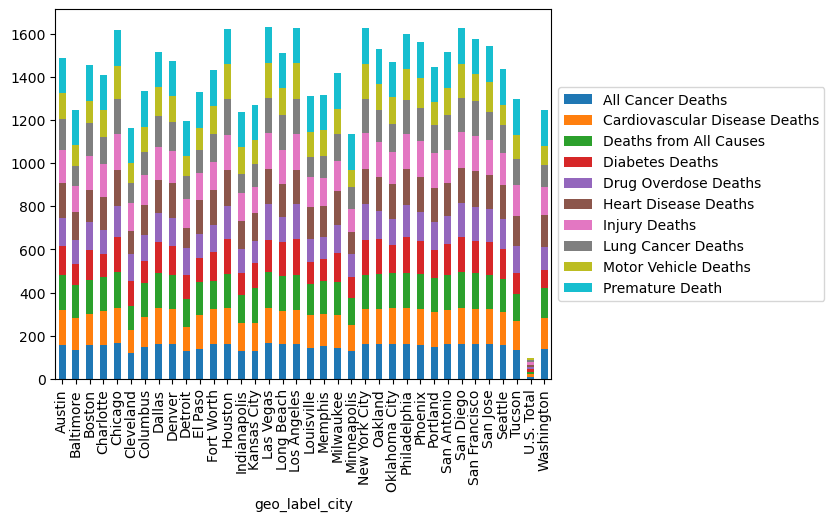

In [10]:
outcome_counts = data.groupby(['geo_label_city', 'metric_item_label']).size().reset_index(name='count')
top_outcomes = outcome_counts.groupby('metric_item_label').sum().sort_values(by='count', ascending=False).head(10).index
outcome_counts_top = outcome_counts[outcome_counts['metric_item_label'].isin(top_outcomes)]

pivot_table = pd.pivot_table(outcome_counts_top, values='count', index='geo_label_city', columns='metric_item_label', fill_value=0)
data = data.drop('metric_source_desc_label_url_fn', axis = 1)

ax = pivot_table.plot(kind='bar', stacked=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



# Data PreProcessing

In [11]:
data.isnull().sum()

metric_item_label                   0
metric_cat_label                    0
metric_subcat_label                 0
metric_item_label_subtitle          0
metric_cat_item_yaxis_label         0
metric_source_desc_label_fn         0
geo_label_city                      0
geo_label_state                  1097
geo_label_citystate                 0
geo_fips_code                    1097
value                             770
date_label                          0
geo_label_proxy_or_real             0
geo_label_proxy_footnote       133002
geo_fips_desc                       0
date_label_proxy_or_real            0
date_label_proxy_footnote      104164
value_ci_flag_yesno                 0
value_95_ci_low                 54914
value_95_ci_high                54904
value_90_ci_low                148292
value_90_ci_high               148292
geo_strata_region                1097
geo_strata_poverty               1097
geo_strata_Population            1097
geo_strata_PopDensity            1097
geo_strata_S

Deleting the columns that contain more than 50% (74'146) missing values.

In [12]:
missing_values = data.isnull().mean()
columns_to_drop = list(missing_values[missing_values > 0.5].index)
data = data.drop(columns_to_drop, axis=1)
columns_to_drop

['geo_label_proxy_footnote',
 'date_label_proxy_footnote',
 'value_90_ci_low',
 'value_90_ci_high',
 'strata_race_sex_label']

Since geo_label_city and geo_label_city gives us the same info as geo_label_city_state, we can drop these two columns

In [13]:
data = data.drop(['geo_label_city', 'geo_label_state'], axis=1)
data.columns

Index(['metric_item_label', 'metric_cat_label', 'metric_subcat_label',
       'metric_item_label_subtitle', 'metric_cat_item_yaxis_label',
       'metric_source_desc_label_fn', 'geo_label_citystate', 'geo_fips_code',
       'value', 'date_label', 'geo_label_proxy_or_real', 'geo_fips_desc',
       'date_label_proxy_or_real', 'value_ci_flag_yesno', 'value_95_ci_low',
       'value_95_ci_high', 'geo_strata_region', 'geo_strata_poverty',
       'geo_strata_Population', 'geo_strata_PopDensity',
       'geo_strata_Segregation', 'strata_race_label', 'strata_sex_label'],
      dtype='object')

Detect numerical and categorical features

In [14]:
num_features = data.select_dtypes(include=['float64', 'int64']).columns
cat_features = data.select_dtypes(include=['object']).columns
num_features, cat_features

(Index(['geo_fips_code', 'value', 'date_label', 'value_95_ci_low',
        'value_95_ci_high'],
       dtype='object'),
 Index(['metric_item_label', 'metric_cat_label', 'metric_subcat_label',
        'metric_item_label_subtitle', 'metric_cat_item_yaxis_label',
        'metric_source_desc_label_fn', 'geo_label_citystate',
        'geo_label_proxy_or_real', 'geo_fips_desc', 'date_label_proxy_or_real',
        'value_ci_flag_yesno', 'geo_strata_region', 'geo_strata_poverty',
        'geo_strata_Population', 'geo_strata_PopDensity',
        'geo_strata_Segregation', 'strata_race_label', 'strata_sex_label'],
       dtype='object'))

### Check for Normality

/Users/charlottekohler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


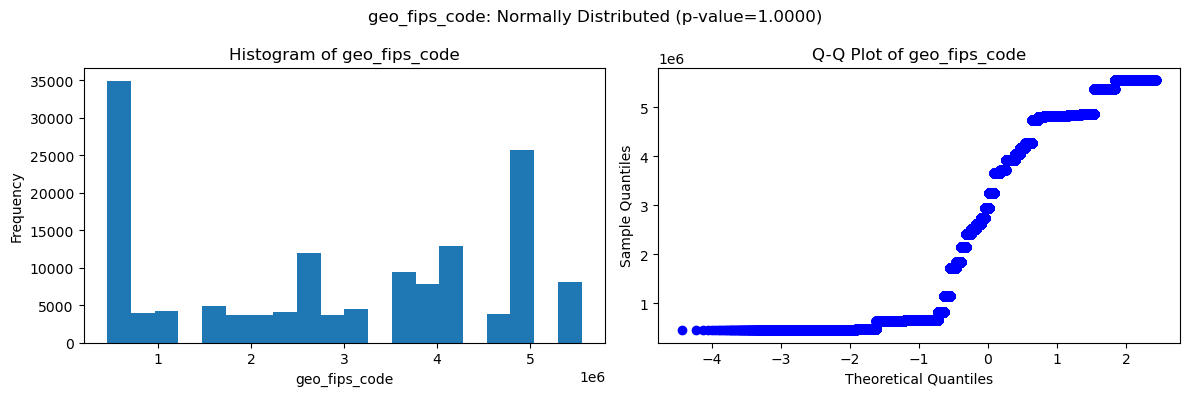

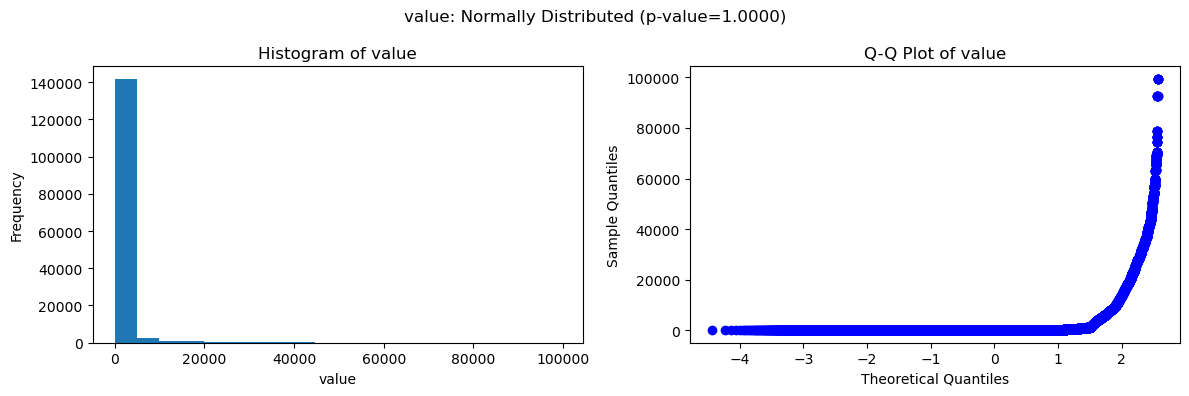

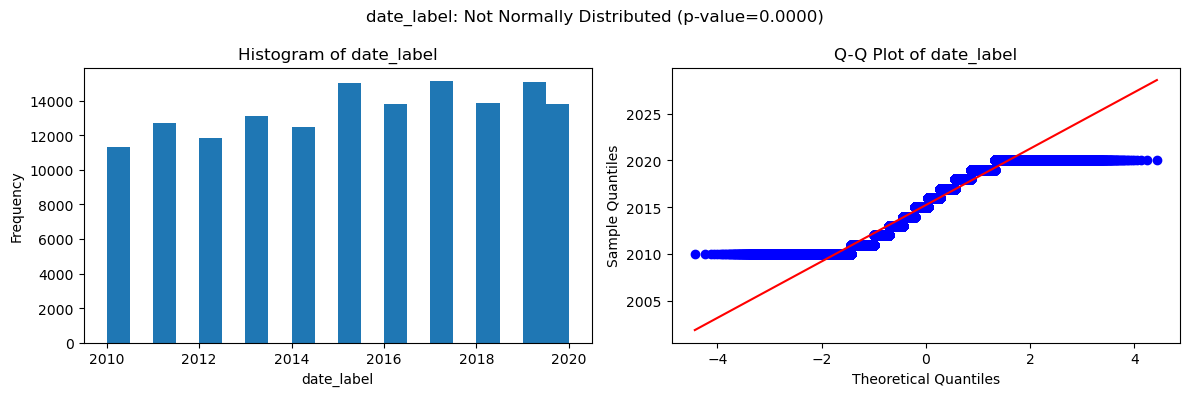

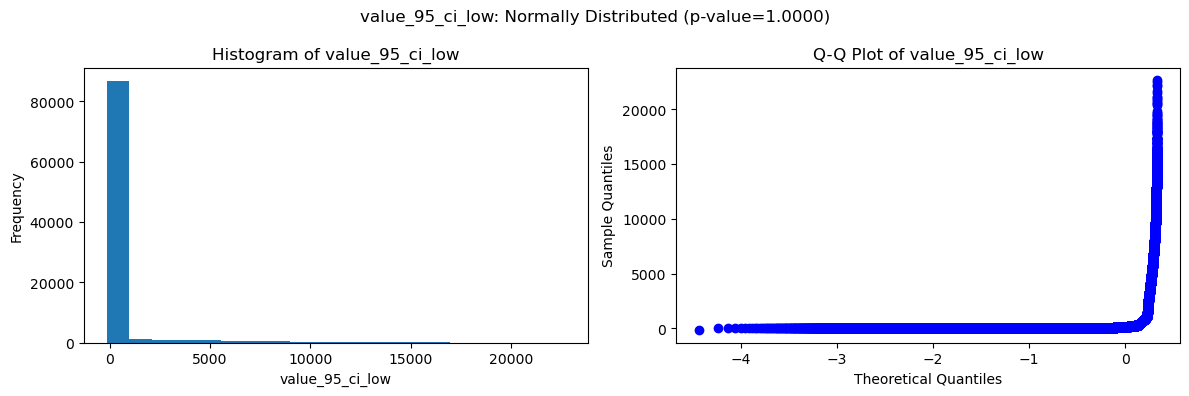

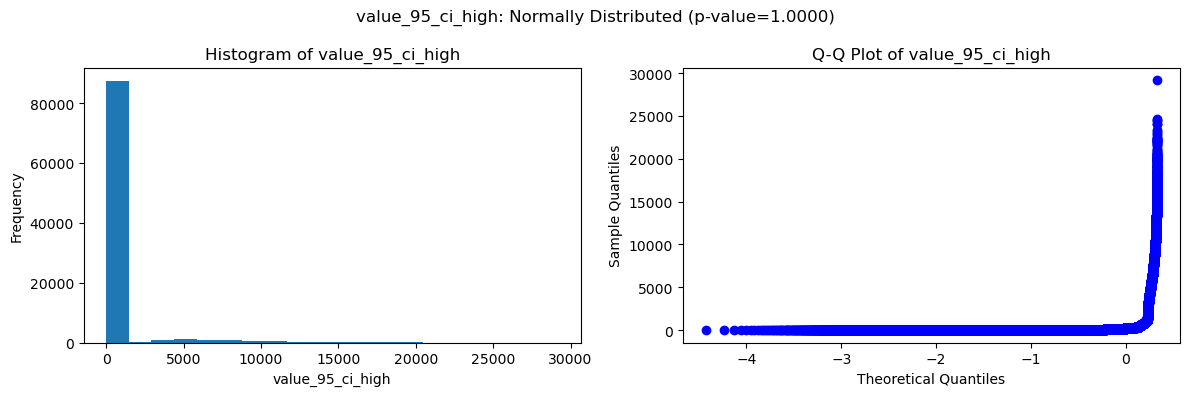

In [15]:
alpha = 0.05  
for column in num_features:
    column_data = data[column] 
    

    statistic, p_value = stats.shapiro(column_data)
    
  
    plt.figure(figsize=(12, 4))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(column_data, bins=20)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    
    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(column_data, dist='norm', plot=plt)
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.title(f'Q-Q Plot of {column}')
    
 
    if p_value > alpha:
        plt.suptitle(f'{column}: Normally Distributed (p-value={p_value:.4f})')
    else:
        plt.suptitle(f'{column}: Not Normally Distributed (p-value={p_value:.4f})')
    
    plt.tight_layout()

Find which columns are binary

In [16]:

# Get number of unique values per column
num_unique = data.nunique()

# Get unique values per column
unique_vals = {}
for col in data.columns:
    unique_vals[col] = data[col].unique()

# Print results
print("Number of unique values per column:")
print(num_unique)
print("\nUnique values per column:")
for col, vals in unique_vals.items():
    print(f"{col}: {vals}")

Number of unique values per column:
metric_item_label                109
metric_cat_label                  11
metric_subcat_label               33
metric_item_label_subtitle       109
metric_cat_item_yaxis_label       16
metric_source_desc_label_fn       12
geo_label_citystate               36
geo_fips_code                     35
value                          96698
date_label                        11
geo_label_proxy_or_real            2
geo_fips_desc                      3
date_label_proxy_or_real           2
value_ci_flag_yesno                2
value_95_ci_low                85213
value_95_ci_high               85458
geo_strata_region                  4
geo_strata_poverty                 2
geo_strata_Population              2
geo_strata_PopDensity              2
geo_strata_Segregation             2
strata_race_label                  7
strata_sex_label                   3
dtype: int64

Unique values per column:
metric_item_label: ['COVID-19 Deaths' 'Diabetes Deaths' 'Walking to Work'

Filling in the missing spots (KNN in numerical and Simple for numerical)

In [17]:
imputerKNN = KNNImputer(n_neighbors=3)
imputerCat = SimpleImputer(strategy='most_frequent')
imputerNum = SimpleImputer(strategy='median')

In [18]:
data[cat_features] = imputerCat.fit_transform(data[cat_features])
data[num_features] = imputerNum.fit_transform(data[num_features])

Since all have high variance but not "date_label" we use median for datasets with high variance and mean imputation for data with low variance.(But "date_label" has no missing value so using median for all)

In [19]:
data[num_features] = imputerNum.transform(data[num_features])
data[cat_features] = imputerCat.transform(data[cat_features])

In [20]:
data.isnull1().sum()

metric_item_label              0
metric_cat_label               0
metric_subcat_label            0
metric_item_label_subtitle     0
metric_cat_item_yaxis_label    0
metric_source_desc_label_fn    0
geo_label_citystate            0
geo_fips_code                  0
value                          0
date_label                     0
geo_label_proxy_or_real        0
geo_fips_desc                  0
date_label_proxy_or_real       0
value_ci_flag_yesno            0
value_95_ci_low                0
value_95_ci_high               0
geo_strata_region              0
geo_strata_poverty             0
geo_strata_Population          0
geo_strata_PopDensity          0
geo_strata_Segregation         0
strata_race_label              0
strata_sex_label               0
dtype: int64

Object columns are nominal 

The other are numerical

## Step 1: Encoding

Encode categorical variables: If your categorical variables are nominal (unordered) variables, you can use one-hot encoding to transform each category into a binary variable. If your categorical variables are ordinal (ordered) variables, you can use label encoding to assign each category a numerical value. You can use libraries such as scikit-learn's OneHotEncoder and OrdinalEncoder to do this.

In [21]:

cat_cols = data.select_dtypes(exclude=['float', 'int']).columns
num_cols = data.select_dtypes(include=['int', 'float']).columns


encoded_data = pd.get_dummies(data[cat_cols], prefix=cat_cols, drop_first=True)
data_encoded = pd.concat([encoded_data, data[num_cols]], axis=1)


In [22]:
data_encoded = data_encoded.astype(float)


Encode target avriable: metric_item_label

## Step 2: Scaling

Scale numerical variables: If your numerical variables are on different scales, you can standardize them to have zero mean and unit variance, or normalize them to have a range of [0, 1]. You can use libraries such as scikit-learn's StandardScaler and MinMaxScaler to do this.

In [23]:

sc = StandardScaler()
scaled_data = sc.fit_transform(data[num_cols])
scaled_data = np.log(scaled_data - scaled_data.min() + 1)
scaled_data = pd.DataFrame(scaled_data, columns=num_cols)
data_scaled = pd.concat([encoded_data, scaled_data], axis=1)


In [24]:
data_scaled

,metric_item_label_Adult Mental Distress,metric_item_label_Adult Obesity,metric_item_label_Adult Physical Inactivity,metric_item_label_Adult Smoking,metric_item_label_All Cancer Deaths,metric_item_label_Breast Cancer Deaths,metric_item_label_COVID-19 Deaths,metric_item_label_Cardiovascular Disease Deaths,metric_item_label_Child Lead Levels 10+ mcg/dL,metric_item_label_Child Lead Levels 5+ mcg/dL,...,strata_race_label_Black,strata_race_label_Hispanic,strata_race_label_White,strata_sex_label_Female,strata_sex_label_Male,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,1.341694,0.936309,1.438134,0.968588,0.971159
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,1.342929,0.941962,1.438134,0.947116,1.042905
2,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,1.348777,0.919132,1.438134,0.922409,0.921830
3,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0.688089,0.943834,1.438134,0.992375,0.988278
4,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0.998243,0.928529,1.438134,0.931201,0.973388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148287,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1.142636,1.344158,1.438134,1.873718,1.799918
148288,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1.449138,1.420249,1.438134,1.956819,1.967608
148289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.344163,1.236067,0.278603,1.633683,1.644656
148290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.449138,1.339306,0.826423,1.748338,1.888009


## Step 3: Split Dataset
Split the dataset into training and test sets: Split the dataset into a training set and a test set, with a typical split of 70% training and 30% test. This will allow you to train your models on the training set and evaluate their performance on the test set.

In [25]:
X = data.values
y = data['metric_item_label'].values

column_names = ['metric_item_label', 'metric_cat_label', 'metric_subcat_label',
       'metric_item_label_subtitle', 'metric_cat_item_yaxis_label',
       'metric_source_desc_label_fn', 'geo_label_citystate', 'geo_fips_code',
       'value', 'date_label', 'geo_label_proxy_or_real', 'geo_fips_desc',
       'date_label_proxy_or_real', 'value_ci_flag_yesno', 'value_95_ci_low',
       'value_95_ci_high', 'geo_strata_region', 'geo_strata_poverty',
       'geo_strata_Population', 'geo_strata_PopDensity',
       'geo_strata_Segregation', 'strata_race_label', 'strata_sex_label']


X = pd.DataFrame(X, columns=column_names) 
y = pd.Series(y, name='metric_item_label')


In [26]:
cat_cols = X.select_dtypes(exclude=['float', 'int']).columns
num_cols = X.select_dtypes(include=['int', 'float']).columns

In [27]:
X = pd.concat([data_encoded, data_scaled], axis=1)
y = data['metric_item_label']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2023)

## Step 4: Feature Selection


In dependence of 'metric_cat_label' if asked

### Random Forest


Text(0.5, 1.0, 'Top 15 features selected by Random Forest')

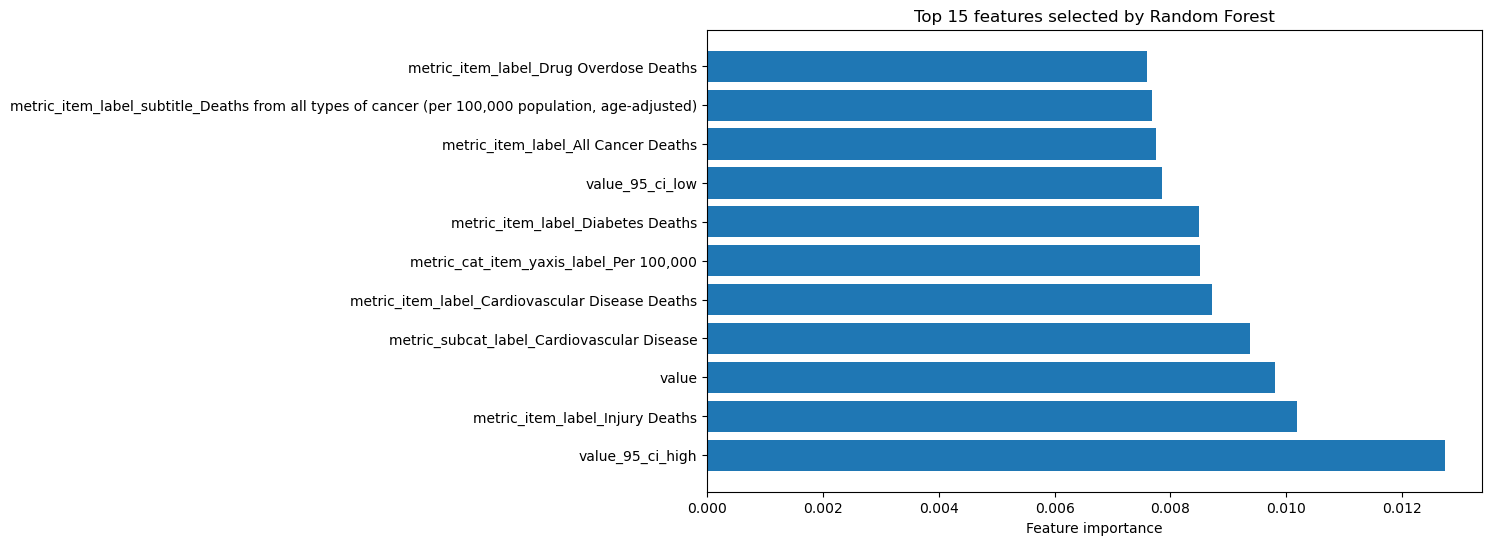

In [29]:
RF = RandomForestClassifier(random_state=43)
RF.fit(X_train, y_train)

importances = RF.feature_importances_
top_indices = importances.argsort()[::-1][:15]
top_features = X_train.columns[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, importances[top_indices])
plt.xlabel('Feature importance')
plt.title('Top 15 features selected by Random Forest')

### Mutual Information Classification

In [30]:
'''
selector = SelectKBest(mutual_info_classif, k=30)
X_new = selector.fit_transform(X_train, y_train)

feature_indices = selector.get_support(indices=True)

selected_features = X_train.columns[feature_indices]

scores = selector.scores_[feature_indices]
plt.figure(figsize=(10, 6))
plt.bar(selected_features, scores)
plt.xticks(rotation=90)
plt.ylabel('Mutual Information Scores')
'''


"\nselector = SelectKBest(mutual_info_classif, k=30)\nX_new = selector.fit_transform(X_train, y_train)\n\nfeature_indices = selector.get_support(indices=True)\n\nselected_features = X_train.columns[feature_indices]\n\nscores = selector.scores_[feature_indices]\nplt.figure(figsize=(10, 6))\nplt.bar(selected_features, scores)\nplt.xticks(rotation=90)\nplt.ylabel('Mutual Information Scores')\n"

In [31]:
X_train

,metric_item_label_Adult Mental Distress,metric_item_label_Adult Obesity,metric_item_label_Adult Physical Inactivity,metric_item_label_Adult Smoking,metric_item_label_All Cancer Deaths,metric_item_label_Breast Cancer Deaths,metric_item_label_COVID-19 Deaths,metric_item_label_Cardiovascular Disease Deaths,metric_item_label_Child Lead Levels 10+ mcg/dL,metric_item_label_Child Lead Levels 5+ mcg/dL,...,strata_race_label_Black,strata_race_label_Hispanic,strata_race_label_White,strata_sex_label_Female,strata_sex_label_Male,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high
38075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1.449138,0.929780,1.178341,0.955138,0.948634
136572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0.305533,0.918020,1.438134,0.907938,0.906085
61147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.809366,0.912300,0.000000,0.907938,0.906085
50878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1.191399,0.912961,0.496259,0.905665,0.903534
98354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0.315069,0.911437,0.674906,0.901686,0.898907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1.191758,0.914378,1.358806,0.910015,0.907189
39427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,1.342929,0.918713,0.957975,0.920651,0.921247
104156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,1.330661,0.918473,1.178341,0.921632,0.918830
22041,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.688089,0.919927,1.178341,0.925789,0.922873


### Pearson (Only for Numerical)

<AxesSubplot:>

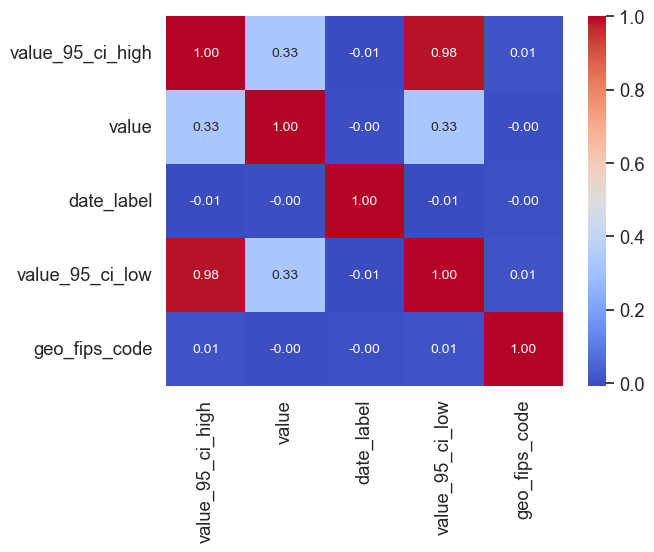

In [32]:
corr_matrix = data.corr(method='pearson')

num_features = 15
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
top_pairs = corr_pairs[corr_pairs!=1][:num_features]
top_features = set(top_pairs.reset_index(level=0).index) | set(top_pairs.reset_index(level=1).index)

sns.set(font_scale=1.2)
sns.heatmap(data[list(top_features)].corr(), cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size": 10})

### ChiSquared Correlation for Categorical Features

In [51]:
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    r_corr = r - ((r-1)**2) / (n-1)
    k_corr = k - ((k-1)**2) / (n-1)
    cramers_v = np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))
    return cramers_v

# Assuming your dataset is stored in a variable called 'data'
categorical_columns = ['metric_item_label', 'metric_cat_label', 'metric_subcat_label',
        'metric_item_label_subtitle', 'metric_cat_item_yaxis_label',
        'metric_source_desc_label_fn', 'geo_label_citystate',
        'geo_label_proxy_or_real', 'geo_fips_desc', 'date_label_proxy_or_real',
        'value_ci_flag_yesno', 'geo_strata_region', 'geo_strata_poverty',
        'geo_strata_Population', 'geo_strata_PopDensity',
        'geo_strata_Segregation', 'strata_race_label', 'strata_sex_label']

# Calculate correlation between all pairs of categorical features
correlations = []

for i in range(len(categorical_columns)):
    for j in range(i+1, len(categorical_columns)):
        feature1 = data[categorical_columns[i]]
        feature2 = data[categorical_columns[j]]
        correlation = cramers_v(feature1, feature2)
        correlations.append((categorical_columns[i], categorical_columns[j], correlation))

# Sort the correlations in descending order
correlations.sort(key=lambda x: x[2], reverse=True)

# Print the 20 best pairs
print("Top 20 Correlated Variable Pairs:")
for pair in correlations[:20]:
    feature1, feature2, correlation = pair
    print(f"{feature1} - {feature2}: {correlation}")

# Create a correlation matrix dataframe
variable_pairs = [(pair[0], pair[1]) for pair in correlations]
correlation_values = [pair[2] for pair in correlations]
correlation_df = pd.DataFrame({'Variable Pair': variable_pairs, 'Correlation': correlation_values})
correlation_matrix = correlation_df.pivot(index='Variable Pair', columns='Variable Pair', values='Correlation')

# Create the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Categorical Variable Correlation Heatmap')


Top 20 Correlated Variable Pairs:
metric_item_label - metric_item_label_subtitle: 1.0
geo_label_citystate - geo_strata_region: 0.9998946891032574
geo_label_citystate - geo_strata_Segregation: 0.9998878959943076
geo_label_citystate - geo_strata_poverty: 0.9998878959943075
geo_label_citystate - geo_strata_PopDensity: 0.9998878959943075
geo_label_citystate - geo_strata_Population: 0.9998878959943074
metric_item_label - metric_subcat_label: 0.9997436589272509
metric_subcat_label - metric_item_label_subtitle: 0.9997436589272509
metric_item_label - metric_cat_item_yaxis_label: 0.999686346451288
metric_item_label_subtitle - metric_cat_item_yaxis_label: 0.999686346451288
metric_item_label - metric_source_desc_label_fn: 0.999672862595226
metric_item_label_subtitle - metric_source_desc_label_fn: 0.999672862595226
metric_item_label - metric_cat_label: 0.9996694917164619
metric_cat_label - metric_item_label_subtitle: 0.9996694917164618
metric_item_label - value_ci_flag_yesno: 0.9678813922326552
me

ValueError: The name Variable Pair occurs multiple times, use a level number